<a href="https://colab.research.google.com/github/devparikh0506/DATA_690_Deep_Learning/blob/main/project_1/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [source](https://github.com/bufuchangfeng/NeuralNetwork/blob/nn/nn_and_cnn.ipynb)

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
np.random.seed(42)

In [5]:
def load_data(path):
    """Loads the MNIST dataset and splits it into training and testing sets.

    Args:
        path (str): Path to the MNIST dataset file.

    Returns:
        Tuple: (x_train, y_train, x_test, y_test)
    """
    with np.load(path) as f:
        # Load training data and labels
        x_train, y_train = f['x_train'], f['y_train']
        # Load testing data and labels
        x_test, y_test = f['x_test'], f['y_test']
        return x_train, y_train, x_test, y_test

# Load MNIST dataset
train_data, train_label, test_data, test_label = load_data('/content/drive/MyDrive/DATA-690-deep-learning/data/mnist.npz')


In [6]:
X_train = (train_data/255 - 0.5)*2
X_test = (test_data/255 - 0.5)*2

In [7]:
X_train.shape

(60000, 28, 28)

In [8]:
train_data = X_train.reshape(-1, 1, 28, 28)

In [9]:
train_label.shape

(60000,)

In [10]:
X_test.shape

(10000, 28, 28)

In [11]:
test_data = X_test.reshape(-1, 1, 28, 28)

In [12]:
train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.2)

In [13]:
train_data.shape

(48000, 1, 28, 28)

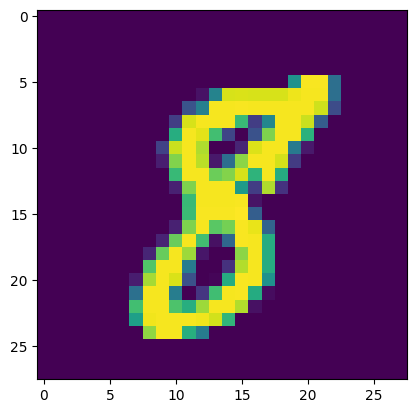

In [14]:
plt.imshow(valid_data[2].reshape(28, 28))
plt.show()


In [15]:
valid_label[2]

8

In [16]:
def label_to_one_hot(y, n_class):
    """Converts labels to one-hot encoding.

    Args:
        y (numpy.ndarray): Array of labels.
        n_class (int): Number of classes.

    Returns:
        numpy.ndarray: One-hot encoded labels.
    """
    one_hot = np.zeros((y.shape[0], n_class))
    for i in range(len(y)):
        one_hot[i][int(y[i])] = 1

    return one_hot

In [17]:
def data_generator(data, label, batch_size):
  """
  Generates batches of data and labels.

  Args:
    data: The input data.
    label: The corresponding labels.
    batch_size: The size of each batch.

  Yields:
    A tuple of (data_batch, label_batch).
  """
  num_samples = len(data)
  num_batches = num_samples // batch_size

  for i in range(num_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    yield data[start:end], label[start:end]

  # If there are remaining samples, yield a smaller batch.
  if num_samples % batch_size != 0:
    yield data[num_batches * batch_size:], label[num_batches * batch_size:]

In [18]:
class Layer(ABC):
  """The base class for NN model layer."""
  def __init__(self):
      super.__init__()

  @abstractmethod
  def forward(self, x):
    raise NotImplementedError

  @abstractmethod
  def backward(self, dout):
    raise NotImplementedError

In [19]:
class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        self.params = {}
        self.params['W'] = np.random.randn(input_dim, output_dim) / np.sqrt(input_dim)
        self.params['b'] = np.random.randn(output_dim)

        self.grads = {}

    def forward(self, x):

        self.x = x

        out = np.dot(x, self.params['W']) + self.params['b']
        return out

    def backward(self, dout):

        self.grads['W'] = np.dot(self.x.T, dout)
        self.grads['b'] = np.sum(dout, axis=0) # further clarify

        return np.dot(dout, self.params['W'].T)

In [20]:
class ReLU(Layer):
    def __init__(self):
        self.params = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0

        return dout

In [21]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

In [22]:
class SoftmaxWithCrossEntropyLoss(Layer):
    def __init__(self):
        self.params = None

    def forward(self, out, y):
        '''
            out: output of last fully connected layer
            y: true label
        '''

        batch_size = out.shape[0]

        out = softmax(out)

        self.out = out
        self.y = y

        log_out = np.log(out + 1e-7)

        loss = np.sum(-log_out * y)

        return loss / batch_size, out

    def backward(self, dout):
        return (self.out - self.y) / batch_size

In [23]:
class Optimizer(ABC):
    """The base class for optimizer."""
    def __init__(self, learning_rate, layers):
        super().__init__()

    @abstractmethod
    def update(self):
        raise NotImplementedError

In [24]:
class SGD(Optimizer):
    """SGD (Stochastic gradient descent) optimizer"""
    def __init__(self, learning_rate, layers):
        self.learning_rate = learning_rate
        self.layers = layers

    def update(self):
        for i in range(len(self.layers)):
          layer = self.layers[i]
          if layer.params is not None:
            for key in layer.params.keys():
              layer.params[key] -= self.learning_rate * layer.grads[key]

In [25]:
def train_and_valid(model, optimizer, train_data, train_label, valid_data, valid_label, epochs, batch_size):
  """
  Trains and validates a neural network model.

  Args:
    model: The neural network model.
    optimizer: The optimizer used for training.
    train_data: The training data.
    train_label: The training labels.
    valid_data: The validation data.
    valid_label: The validation labels.
    epochs: The number of training epochs.
    batch_size: The batch size for training.
  """
  for epoch in range(epochs):
    # Shuffle training data for each epoch
    train_data, train_label = shuffle(train_data, train_label)

    # Training loop
    train_loss = 0
    train_correct = 0
    for data_batch, label_batch in data_generator(train_data, train_label, batch_size):
      # print(f"data_batch shape: {data_batch.shape}")
      # print(f"label_batch shape: {label_batch.shape}")
      loss, output = model.forward(data_batch, label_batch)
      train_loss += loss
      train_correct += np.sum(np.argmax(output, axis=1) == label_batch)
      model.backward()
      optimizer.update()

    # Validation loop
    valid_loss = 0
    valid_correct = 0
    for data_batch, label_batch in data_generator(valid_data, valid_label, batch_size):
      loss, output = model.forward(data_batch, label_batch)
      valid_loss += loss
      valid_correct += np.sum(np.argmax(output, axis=1) == label_batch)

    print(f'Epoch: {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_data):.4f}, Train Acc: {train_correct / len(train_data):.4f}, Valid Loss: {valid_loss / len(valid_data):.4f}, Valid Acc: {valid_correct / len(valid_data):.4f}')

In [26]:
def test(model, test_data, test_label, batch_size=1):
  """
  Tests the neural network model on the test dataset.

  Args:
    model: The neural network model.
    test_data: The test data.
    test_label: The test labels.
    batch_size: The batch size for testing.
  """
  test_correct = 0
  for data_batch, label_batch in data_generator(test_data, test_label, batch_size):
    _, output = model.forward(data_batch, label_batch)
    test_correct += np.sum(np.argmax(output, axis=1) == label_batch)

  print(f'Test Acc: {test_correct / len(test_data):.4f}')

In [27]:
def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return int((input_size + 2*pad - filter_size) / stride) + 1

In [28]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : The input data, usually images or tensors with 4 dimensions.
    filter_h : The height of the filter
    filter_w : The width of the filter
    stride : The stride of sliding
    pad : The number of padding

    Returns
    -------
    col : 2 dimensional array of shape (N*out_h*out_w, filter_h*filter_w)
    """
    N, C, H, W = input_data.shape
    # out_h = conv_output_size(H, filter_h, stride, pad)
    # out_w = conv_output_size(W, filter_w, stride, pad)
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    # print(out_h, out_w)

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : tuple to show the shape of input data.（example：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    # out_h = conv_output_size(H, filter_h, stride, pad)
    # out_w = conv_output_size(W, filter_w, stride, pad)
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [29]:
class Conv2d(Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, pad=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size  # Should be a tuple (height, width)
        self.stride = stride
        self.pad = pad

        # Initialize weights and biases
        self.params = {}
        self.params['W'] = np.random.randn(
            out_channels, in_channels, kernel_size[0], kernel_size[1]
        )
        self.params['b'] = np.random.randn(out_channels)

        # Initialize gradients
        self.grads = {}
        self.grads['W'] = np.zeros_like(self.params['W'])
        self.grads['b'] = np.zeros_like(self.params['b'])

        # Variables for forward and backward pass
        self.x = None
        self.col = None
        self.col_W = None

    def forward(self, x):
        W, b = self.params['W'], self.params['b']
        FN, C, FH, FW = W.shape
        N, _, H, W_ = x.shape
        out_h = (H + 2 * self.pad - FH) // self.stride + 1
        out_w = (W_ + 2 * self.pad - FW) // self.stride + 1

        # Convert input data to column shape
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = W.reshape(FN, -1).T  # Shape: (C*FH*FW, FN)

        # Compute output
        out = np.dot(col, col_W) + b  # Shape: (N*out_h*out_w, FN)
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)  # Shape: (N, FN, out_h, out_w)

        # Save variables for backward pass
        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        # print(f"dout shape: {dout.shape}")
        W = self.params['W']
        FN, C, FH, FW = W.shape

        # print(f"dout shape: {dout.shape}")
        # print(f"FN: {FN}, C: {C}, FH: {FH}, FW: {FW}")

        # Reshape dout appropriately
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        # Compute gradients with respect to bias and weights
        self.grads['b'] = np.sum(dout, axis=0)
        dW = np.dot(self.col.T, dout)
        self.grads['W'] = dW.transpose(1, 0).reshape(FN, C, FH, FW)

        # Compute gradient with respect to input data
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        # print(f"dx shape: {dx.shape}")

        return dx


In [30]:
class MaxPool2d(Layer):
    """
    Implements the max pooling operation for convolutional layers.
    """

    def __init__(self, kernel_size=(2, 2), stride=2, pad=0):
        # Pooling parameters
        self.pool_h = kernel_size[0]
        self.pool_w = kernel_size[1]
        self.stride = stride
        self.pad = pad

        # No learnable parameters in pooling layer
        self.params = {}
        self.grads = {}

        # Variables for forward and backward pass
        self.x = None
        self.arg_max = None
        self.out_h = None
        self.out_w = None
        self.pool_size = self.pool_h * self.pool_w

    def forward(self, x):
        """
        Forward pass for the max pooling layer.

        Parameters
        ----------
        x : Input data of shape (N, C, H, W)

        Returns
        -------
        out : Output data after max pooling
        """
        N, C, H, W = x.shape

        # Calculate output dimensions
        self.out_h = (H + 2 * self.pad - self.pool_h) // self.stride + 1
        self.out_w = (W + 2 * self.pad - self.pool_w) // self.stride + 1

        # Convert input data to column shape
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # Reshape to (N, C, out_h, out_w, pool_h * pool_w)
        col = col.reshape(N, C, self.out_h, self.out_w, self.pool_size)
        # Move channels to the second dimension and flatten
        col = col.transpose(0, 2, 3, 1, 4).reshape(-1, self.pool_size)

        # Perform max pooling
        self.arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)

        # Reshape output to (N, C, out_h, out_w)
        out = out.reshape(N, self.out_h, self.out_w, C).transpose(0, 3, 1, 2)

        # Save input and indices for backward pass
        self.x = x

        return out

    def backward(self, dout):
        """
        Backward pass for the max pooling layer.

        Parameters
        ----------
        dout : Upstream derivatives of shape (N, C, out_h, out_w)

        Returns
        -------
        dx : Gradient with respect to input data x
        """
        # print(f"dout shape: {dout.shape}")
        # print(f"self.arg_max shape: {self.arg_max.shape}")
        N, C, out_h, out_w = dout.shape

        # Flatten dout and initialize gradient array
        dout_flat = dout.transpose(0, 2, 3, 1).reshape(-1)
        dmax = np.zeros((dout_flat.size, self.pool_size))

        # Place dout values into appropriate positions in dmax using arg_max
        dmax[np.arange(dout_flat.size), self.arg_max] = dout_flat

        # Reshape dmax to match the shape needed for col2im
        dmax = dmax.reshape(N, out_h, out_w, C, self.pool_size)
        dmax = dmax.transpose(0, 3, 1, 2, 4).reshape(N * C * out_h * out_w, self.pool_size)

        # Reconstruct the gradient w.r.t input data
        dx = col2im(dmax, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        # print(f"dx shape: {dx.shape}")

        return dx


In [31]:
c = Conv2d(2, 6, (3, 3), 1, 1)

x = np.random.randn(1, 2, 56, 56)

out = c.forward(x)

c.backward(out)

array([[[[-6.97165763e-01,  2.04338390e+01, -2.22113000e+00, ...,
          -6.99341416e+01, -1.94626636e+01, -2.20799297e+01],
         [ 2.40498133e+01,  3.07943956e+01,  4.90695542e+01, ...,
          -4.93678687e+01, -6.95717891e+00,  3.88145423e-02],
         [-2.07383901e+01,  1.20252295e+01,  3.43859480e+01, ...,
           7.74732715e+01,  2.13621418e+01,  1.98068746e+01],
         ...,
         [ 1.79746397e+01, -7.42700354e+00, -4.15900626e+01, ...,
           8.51825979e+01, -8.89696416e+01,  8.54719779e+01],
         [ 3.55450233e+01, -5.19599667e+01, -1.23699609e+01, ...,
           2.53560080e+01, -1.24085472e+01,  1.78211139e+01],
         [ 1.29443671e+01,  7.38454946e-01, -1.17029897e+01, ...,
           2.60766657e+01,  3.24359677e+01, -1.27285299e+01]],

        [[ 4.51360327e+01,  8.37326935e+00,  3.55129490e+01, ...,
           2.12434395e+01, -5.95649352e+00, -1.77347578e+01],
         [-3.49702851e+01,  1.57964858e-01, -6.35077589e+00, ...,
          -3.57931177e

In [32]:
m = MaxPool2d((2, 2), 2)

x = np.random.randn(3, 2, 56, 56)

out = m.forward(x)

m.backward(out)

array([[[[ 0.        ,  1.43642738,  0.        , ..., -0.0718622 ,
           0.5444059 ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 1.46843173,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.47298917],
         ...,
         [ 0.        ,  0.2413208 ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  1.21410305],
         [ 0.96402032,  0.        ,  0.23170115, ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  1.24924944,  0.        , ...,  0.        ,
           0.98165191,  0.        ],
         [ 0.        ,  1.31616059,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.40274051,  0.        

Defining droput layer

In [104]:
class Dropout(Layer):
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None
        self.params = None

    def forward(self, x):
        if self.dropout_rate == 0:
            return x

        # Creating dropout mask (1 = keep, 0 = drop)
        self.mask = np.random.binomial(1, 1-self.dropout_rate, size=x.shape) / (1-self.dropout_rate)
        return x * self.mask

    def backward(self, dout):
        return dout * self.mask


In [107]:
x = np.random.randn(3, 2, 56, 56)
drop_out = Dropout(0.5)
out = drop_out.forward(x)
drop_out.backward(out)

array([[[[ 0.        ,  0.        , -2.63244907, ..., -0.        ,
           5.0334409 ,  0.        ],
         [-0.        ,  5.05632502, -0.        , ..., -3.73094382,
           7.57012586, -0.        ],
         [ 5.58253637, -0.        ,  0.07964916, ..., -3.66704961,
          -5.59414865,  1.95333982],
         ...,
         [-0.        , -0.        , -0.        , ...,  3.6451841 ,
           0.4541713 ,  0.        ],
         [ 0.        , -0.23655534,  0.55255161, ...,  0.96871255,
           1.65212866,  6.75158352],
         [ 0.        ,  0.        ,  2.60283542, ...,  0.        ,
          -1.56689275, -0.        ]],

        [[ 0.27597265,  6.13164271, -4.33439464, ..., -0.20557832,
          -0.        ,  1.00815956],
         [ 1.35981663, -0.        , -0.        , ...,  0.        ,
          -0.        , -4.99812806],
         [ 4.11029313,  0.        , -0.        , ..., -0.        ,
          -2.05533135, -0.        ],
         ...,
         [-0.14821361,  2.05143705

In [229]:
class GlobalAvgPool2d(Layer):
    def __init__(self, keepdims=False):
        self.params = None
        self.x_shape = None
        self.keepdims = keepdims

    def forward(self, x):
        self.x_shape = x.shape
        return np.mean(x, axis=(2, 3), keepdims=self.keepdims)

    def backward(self, dout):
        batch_size, channels, height, width = self.x_shape
        if not self.keepdims:
            dout = dout.reshape(batch_size, channels, 1, 1)
        dx = np.ones(self.x_shape) * dout / (height * width)
        return dx

In [232]:
x = np.random.randn(3, 2, 56, 56)
global_avg_pool = GlobalAvgPool2d()
out = global_avg_pool.forward(x)
print(out.shape)
global_avg_pool.backward(out)

(3, 2)


array([[[[-6.10764264e-07, -6.10764264e-07, -6.10764264e-07, ...,
          -6.10764264e-07, -6.10764264e-07, -6.10764264e-07],
         [-6.10764264e-07, -6.10764264e-07, -6.10764264e-07, ...,
          -6.10764264e-07, -6.10764264e-07, -6.10764264e-07],
         [-6.10764264e-07, -6.10764264e-07, -6.10764264e-07, ...,
          -6.10764264e-07, -6.10764264e-07, -6.10764264e-07],
         ...,
         [-6.10764264e-07, -6.10764264e-07, -6.10764264e-07, ...,
          -6.10764264e-07, -6.10764264e-07, -6.10764264e-07],
         [-6.10764264e-07, -6.10764264e-07, -6.10764264e-07, ...,
          -6.10764264e-07, -6.10764264e-07, -6.10764264e-07],
         [-6.10764264e-07, -6.10764264e-07, -6.10764264e-07, ...,
          -6.10764264e-07, -6.10764264e-07, -6.10764264e-07]],

        [[ 7.38793172e-07,  7.38793172e-07,  7.38793172e-07, ...,
           7.38793172e-07,  7.38793172e-07,  7.38793172e-07],
         [ 7.38793172e-07,  7.38793172e-07,  7.38793172e-07, ...,
           7.38793172e

Adding batch normalization layer

In [233]:
class BatchNorm2d(Layer):
    def __init__(self, num_features, eps=1e-5, momentum=0.9):
        self.params = {}
        self.params['gamma'] = np.ones(num_features)
        self.params['beta'] = np.zeros(num_features)

        self.grads = {}
        self.grads['gamma'] = np.zeros_like(self.params['gamma'])
        self.grads['beta'] = np.zeros_like(self.params['beta'])

        self.eps = eps
        self.m = momentum


        self.rmean = np.zeros(num_features)
        self.rvar = np.ones(num_features)


        self.x_norm = None
        self.x = None
        self.batch_mean = None
        self.batch_var = None

    def forward(self, x):
        N, C, H, W = x.shape
        self.x = x

        x_reshaped = x.transpose(0, 2, 3, 1).reshape(-1, C)

        self.batch_mean = np.mean(x_reshaped, axis=0)
        self.batch_var = np.var(x_reshaped, axis=0)


        self.rmean = self.m * self.rmean + (1 - self.m) * self.batch_mean
        self.rvar = self.m * self.rvar + (1 - self.m) * self.batch_var

        # Normalize
        x_norm = (x_reshaped - self.batch_mean) / np.sqrt(self.batch_var + self.eps)
        self.x_norm = x_norm

        # Scale and shift
        out = self.params['gamma'] * x_norm + self.params['beta']

        # Reshape back
        out = out.reshape(N, H, W, C).transpose(0, 3, 1, 2)

        return out

    def backward(self, dout):
        N, C, H, W = dout.shape

        dout_reshaped = dout.transpose(0, 2, 3, 1).reshape(-1, C)


        self.grads['gamma'] = np.sum(dout_reshaped * self.x_norm, axis=0)
        self.grads['beta'] = np.sum(dout_reshaped, axis=0)

        dx_norm = dout_reshaped * self.params['gamma']


        dvar = np.sum(dx_norm * (self.x.transpose(0, 2, 3, 1).reshape(-1, C) - self.batch_mean) *
                      -0.5 * (self.batch_var + self.eps)**(-1.5), axis=0)

        N_reshaped = N * H * W
        dmean = np.sum(dx_norm * -1.0 / np.sqrt(self.batch_var + self.eps), axis=0) + \
                dvar * np.mean(-2.0 * (self.x.transpose(0, 2, 3, 1).reshape(-1, C) - self.batch_mean), axis=0)

        dx_reshaped = dx_norm / np.sqrt(self.batch_var + self.eps) + \
                     dvar * 2.0 * (self.x.transpose(0, 2, 3, 1).reshape(-1, C) - self.batch_mean) / N_reshaped + \
                     dmean / N_reshaped

        dx = dx_reshaped.reshape(N, H, W, C).transpose(0, 3, 1, 2)

        return dx

Adding ADAM optimizer

referred from: https://www.datacamp.com/tutorial/adam-optimizer-tutorial

In [234]:
class Adam(Optimizer):
    """Adam optimizer"""
    def __init__(self, learning_rate, layers, beta1=0.9, beta2=0.999, eps=1e-8):
        self.learning_rate = learning_rate
        self.layers = layers
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {}
        self.v = {}
        self.t = 0

        # Initialize moment vectors
        for i, layer in enumerate(self.layers):
            if layer.params is not None:
                for key in layer.params.keys():
                    self.m[(i, key)] = np.zeros_like(layer.params[key])
                    self.v[(i, key)] = np.zeros_like(layer.params[key])

    def update(self):
        self.t += 1

        for i, layer in enumerate(self.layers):
            if layer.params is not None:
                for key in layer.params.keys():
                    grad = layer.grads[key]

                    self.m[(i, key)] = self.beta1 * self.m[(i, key)] + (1 - self.beta1) * grad

                    self.v[(i, key)] = self.beta2 * self.v[(i, key)] + (1 - self.beta2) * (grad ** 2)

                    m_corrected = self.m[(i, key)] / (1 - self.beta1 ** self.t)

                    v_corrected = self.v[(i, key)] / (1 - self.beta2 ** self.t)

                    layer.params[key] -= self.learning_rate * m_corrected / (np.sqrt(v_corrected) + self.eps)

In [228]:
# ========== OLD NETWORK ==========

# class CNN:
#     def __init__(self):
#         self.layers = []
#         self.layers.append(Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), stride=1, pad=0))
#         self.layers.append(ReLU())
#         self.layers.append(MaxPool2d(kernel_size=(2, 2), stride=2))
#         self.layers.append(Conv2d(in_channels=6, out_channels=16, kernel_size=(3, 3), stride=1, pad=0))
#         self.layers.append(ReLU())
#         self.layers.append(MaxPool2d(kernel_size=(2, 2), stride=2))
#         self.layers.append(Linear(input_dim=400, output_dim=120))
#         self.layers.append(Linear(input_dim=120, output_dim=84))
#         self.layers.append(Linear(input_dim=84, output_dim=10))
#         self.layers.append(SoftmaxWithCrossEntropyLoss())

#     def forward(self, x, y):

#         batch_size = x.shape[0]

#         y = label_to_one_hot(y, 10)

#         split_index = 6
#         for layer in self.layers[:split_index]:
#             x = layer.forward(x)
#         self.shape_before_flatten = x.shape
#         x = x.reshape(batch_size, -1)
#         print(self.shape_before_flatten, x.shape)
#         x = self.layers[-4].forward(x)
#         x = self.layers[-3].forward(x)
#         x = self.layers[-2].forward(x)

#         return self.layers[-1].forward(x, y)


#     def backward(self):
#         dout = 1
#         for idx, layer in enumerate(self.layers[::-1]):
#             if idx != 4:
#                 dout = layer.backward(dout)
#             else:
#                 dout = dout.reshape(self.shape_before_flatten)
#                 dout = layer.backward(dout)

In [241]:
class CNN:
    def __init__(self):
        self.layers = []

        self.layers.append(Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), stride=1, pad=0))
        self.layers.append(BatchNorm2d(num_features=6))
        self.layers.append(ReLU())
        self.layers.append(Dropout(dropout_rate=0.30))
        self.layers.append(MaxPool2d(kernel_size=(2, 2), stride=2))

        self.layers.append(Conv2d(in_channels=6, out_channels=16, kernel_size=(3, 3), stride=1, pad=0))
        self.layers.append(ReLU())
        self.layers.append(Dropout(dropout_rate=0.30))
        self.layers.append(GlobalAvgPool2d())

        self.layers.append(Linear(input_dim=16, output_dim=32))
        self.layers.append(ReLU())
        self.layers.append(Dropout(dropout_rate=0.5))
        self.layers.append(Linear(input_dim=32, output_dim=10))
        self.layers.append(SoftmaxWithCrossEntropyLoss())

    def forward(self, x, y):

        batch_size = x.shape[0]

        y = label_to_one_hot(y, 10)

        for layer in self.layers[:-1]:
            x = layer.forward(x)

        return self.layers[-1].forward(x, y)


    def backward(self):
        dout = 1
        for idx, layer in enumerate(self.layers[::-1]):
            dout = layer.backward(dout)

In [242]:
learning_rate = 5e-3
epochs = 10
batch_size = 256

In [243]:
cnn_model = CNN()
adam_optimizer = Adam(learning_rate, cnn_model.layers)

train_and_valid(cnn_model, adam_optimizer, train_data, train_label, valid_data, valid_label, epochs, batch_size)

Epoch: 1/10, Train Loss: 0.0087, Train Acc: 0.2056, Valid Loss: 0.0067, Valid Acc: 0.3541
Epoch: 2/10, Train Loss: 0.0057, Train Acc: 0.4763, Valid Loss: 0.0050, Valid Acc: 0.5415
Epoch: 3/10, Train Loss: 0.0045, Train Acc: 0.5979, Valid Loss: 0.0041, Valid Acc: 0.6349
Epoch: 4/10, Train Loss: 0.0040, Train Acc: 0.6511, Valid Loss: 0.0038, Valid Acc: 0.6705
Epoch: 5/10, Train Loss: 0.0036, Train Acc: 0.6853, Valid Loss: 0.0035, Valid Acc: 0.7026
Epoch: 6/10, Train Loss: 0.0033, Train Acc: 0.7247, Valid Loss: 0.0031, Valid Acc: 0.7432
Epoch: 7/10, Train Loss: 0.0030, Train Acc: 0.7476, Valid Loss: 0.0029, Valid Acc: 0.7568
Epoch: 8/10, Train Loss: 0.0028, Train Acc: 0.7678, Valid Loss: 0.0028, Valid Acc: 0.7719
Epoch: 9/10, Train Loss: 0.0026, Train Acc: 0.7827, Valid Loss: 0.0026, Valid Acc: 0.7883
Epoch: 10/10, Train Loss: 0.0026, Train Acc: 0.7920, Valid Loss: 0.0025, Valid Acc: 0.7957


In [244]:
test(cnn_model, test_data, test_label)

Test Acc: 0.8015
